In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import export_graphviz
from IPython.display import Image
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

%matplotlib inline

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [2]:
dataset = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')
dataset.drop('id', axis=1, inplace=True)
dataset.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
for train_indeces, test_indeces in split.split(dataset, y=dataset['stroke']):
    train = dataset.loc[train_indeces]
    test = dataset.loc[test_indeces]

In [4]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Conclusions:
The older a person gets, the higher are their chances of having a stroke. At least 47% of people, who had a stroke, smoked during some period of their lives. High blood sugar levels are also indicative of a possible stroke, as well as excessive weight. People, who selected "children" and 'never worked' as their work type, are most likely to not have a stroke (1/533). On the other hand, self-employed people are more prone to have a stroke than others.

In [5]:
def prepare_data(data, params=None, engineer=True):
    
    if engineer:
        filter_ = (data.age < 30) | (data.bmi < 20) | (data.bmi > 50)
        data['highly_unlikely'] = filter_.astype(int)
        #outlier
        outlier = data.loc[(data.age < 10) & data.stroke == 1].index
        data.drop(outlier, axis=0, inplace=True)
        
    gender_other = data.loc[data.gender == 'Other'].index
    data.drop(gender_other, axis=0, inplace=True)
    data.reset_index(inplace=True, drop=True)
    
    cat = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    
    if (params != None):
        transformer.set_params(**params)
    
    transformer = ColumnTransformer([
    ('1hot', OneHotEncoder(drop='first', sparse_output=False), cat),
    ('impute', SimpleImputer(strategy='median'), ['bmi'])
    ], verbose_feature_names_out=False,
       remainder='passthrough')
    
    new_data = transformer.fit_transform(data)
    data_df = pd.DataFrame(new_data, columns=transformer.get_feature_names_out())
    return data_df
    

In [6]:
train = prepare_data(train)

In [7]:
class Validation:
    def __init__(self, data, estimator, params):
        self.params = params
        self.X = data.drop('stroke', axis=1)
        self.y = data.stroke
        self.estimator = estimator
           
    def build_param_grid(self, params):
        first_key = list(params.keys())[0]
        dots = []
        
        values = params.pop(first_key)
        if (params):
            for dot in self.build_param_grid(params):
                for value in values:
                    dot_copy = dot.copy()
                    dot_copy[first_key] = value
                    dots.append(dot_copy)
            return dots        
        else: 
            for value in values:
                dot = {}
                dot[first_key] = value
                dots.append(dot)
            return dots    
    
    
    def run(self, return_output = False, verbose = 0, cv=5, img_size = (650, 500)):
        output = []
        params_copy = params.copy()
        param_grid = self.build_param_grid(params_copy)        
        
        for dot in param_grid:
            self.estimator.set_params(**dot)
            predictions = cross_val_predict(self.estimator, self.X, self.y, cv=cv, verbose=verbose)
            
            score = roc_auc_score(self.y, predictions)
            
            self.estimator.fit(self.X, self.y)
            
            export_graphviz(
                tree,
                feature_names = self.X.columns,
                out_file='tree.dot',
                filled=True)

            !dot -Tpng tree.dot -o tree.png
            img = Image("tree.png", width=img_size[0], height=img_size[1])
    
            
            result = (score, confusion_matrix(self.y, predictions), dot, self.estimator.feature_importances_, img, predictions)
            output.append(result)
        
        output.sort(key=lambda x: x[0], reverse=True)
        
        self.best_score_ = output[0][0]
        self.best_matrix_ = output[0][1]
        self.best_params_ = output[0][2]
        self.best_importances_ = output[0][3]
        self.best_image_ = output[0][4]
        self.best_predictions_ = output[0][5]
        
        if return_output:
            return output
        else:
            return  

I chose ROC AUC as a metric because in this problem our main goal is to detect as many people, who might have a stroke, as possible, without filling up the hospitals and worrying the ones that are healthy.

In [8]:
tree = DecisionTreeClassifier(class_weight='balanced', criterion='entropy')

params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_leaf': [1, 5, 10, 15, 20, 30],
          'max_leaf_nodes': [None, 10, 20, 50, 100]}

validation = Validation(train, tree, params)
output = validation.run(return_output = True)

In [9]:
validation.best_params_, validation.best_score_

({'max_leaf_nodes': None, 'min_samples_leaf': 1, 'max_depth': 3},
 0.75918911335578)

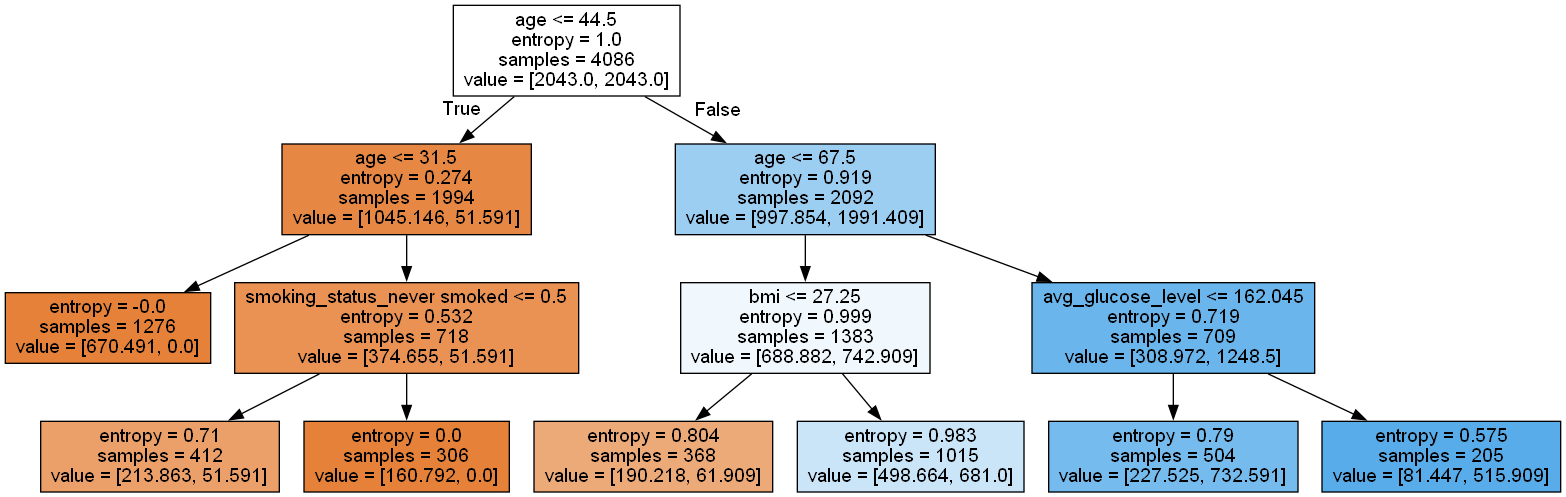

In [10]:
validation.best_image_

The older you get, the more likely you'll have a stroke. People between 45 and 68 years old might have a stroke if they have excessive weight. If you are 68 and older, and your blood sugar is really high, you are at the big risk of having a stroke. Young people are fine, but there is a slight possibility, if their bmi is 24 or higher, and they smoke. 
The model shows that age is the decisive factor, although habits and nutrition can affect the odds, especially for middle-aged people. A job and a place of living had no influence on the results.  

In [11]:
from sklearn.metrics import roc_curve
def predict_on_test(validation = validation , test = test):
    test = prepare_data(test)
    y_test = test.stroke
    X_test = test.drop('stroke', axis=1)
    tree = DecisionTreeClassifier(class_weight='balanced', criterion='entropy')
    tree.set_params(**validation.best_params_)
    tree.fit(validation.X, validation.y)
    test_pred = tree.predict(X_test)
    plot_best_roc_curve(y_test, test_pred)
    return roc_auc_score(y_test, test_pred)


def plot_best_roc_curve(y_true, pred):
        fpr, tpr, thresholds = roc_curve(y_true, pred)
        plt.rcParams["figure.figsize"] = (5,5)
        plt.plot(fpr, tpr, linewidth=2)
        plt.plot([0,1], [0,1], 'k--')
        plt.show()
        return    

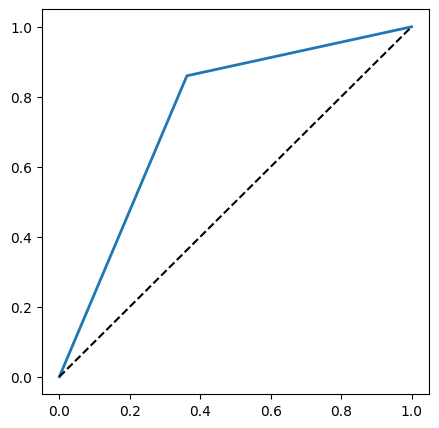

0.7489300411522632

In [12]:
predict_on_test()

In [13]:
features = list(train.columns)
features.remove('stroke')

In [14]:
importances = list(zip(features, validation.best_importances_))
importances.sort(key = lambda x: x[1], reverse=True)
for feature in importances:
    print(feature)

('age', 0.9133421476652831)
('bmi', 0.047653567446039935)
('smoking_status_never smoked', 0.026716276456365116)
('avg_glucose_level', 0.012288008432311804)
('gender_Male', 0.0)
('ever_married_Yes', 0.0)
('work_type_Never_worked', 0.0)
('work_type_Private', 0.0)
('work_type_Self-employed', 0.0)
('work_type_children', 0.0)
('Residence_type_Urban', 0.0)
('smoking_status_formerly smoked', 0.0)
('smoking_status_smokes', 0.0)
('hypertension', 0.0)
('heart_disease', 0.0)
('highly_unlikely', 0.0)


In [20]:
errors = validation.best_predictions_ - validation.y
train['errors'] = ['correct' if error == 0 else 'undershoot' if error == -1 else 'overshoot' for error in list(errors)]
errors = errors.loc[errors!=0]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_35948\1541752614.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


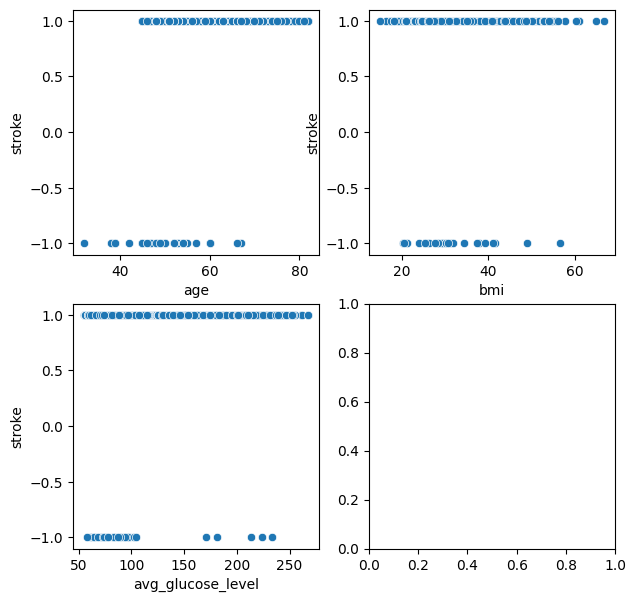

In [21]:
fig, ax =plt.subplots(2,2, figsize=(7, 7))
ax = ax.flatten()
i = 0
for feature in ['age', 'bmi', 'avg_glucose_level']:
    sns.scatterplot(y=errors, x=train[feature], ax=ax[i])
    i +=1
fig.show()

In [22]:
features.remove('age')
features.remove('bmi')
features.remove('avg_glucose_level')

In [23]:
erdf = pd.DataFrame(columns=['index', 'correct','overshoot', 'undershoot'])
for feature in features:
    rows = []
    for i in [0,1]:
        correct = train.loc[(train[feature] == i) & (train['errors'] == 'correct')].shape[0]
        undershoot = train.loc[(train[feature] == i) & (train['errors'] == 'undershoot')].shape[0]
        overshoot = train.loc[(train[feature] == i) & (train['errors'] == 'overshoot')].shape[0]
        
        rows += [{'index': feature+str(i), 'correct': correct, 'undershoot':undershoot, 'overshoot':overshoot}]
    
    new_df = pd.DataFrame(rows)
    erdf = pd.concat([erdf, new_df], axis=0, ignore_index=True)       
erdf.head()  

,index,correct,overshoot,undershoot
0,gender_Male0,1623,755,19
1,gender_Male1,1075,607,7
2,ever_married_Yes0,1264,89,4
3,ever_married_Yes1,1434,1273,22
4,work_type_Never_worked0,2683,1362,26


In [24]:
def search(filter_, name):
    rows = []

    correct = train.loc[(filter_) & (train['errors'] == 'correct')].shape[0]
    undershoot = train.loc[(filter_) & (train['errors'] == 'undershoot')].shape[0]
    overshoot = train.loc[(filter_) & (train['errors'] == 'overshoot')].shape[0]

    rows += [{'index': name, 'correct': correct, 'overshoot':overshoot, 'undershoot':undershoot}]

    new_df = pd.DataFrame(rows)
    return new_df      

In [25]:
filter_ = (train.age < 30) | (train.bmi < 20) | (train.bmi > 50)
filter_ = filter_ 
search(filter_, 'highly unlikely')

,index,correct,overshoot,undershoot
0,highly unlikely,1236,40,1
